In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

1.8.1
True
11.1


In [2]:
import json

with open("sel_examples.json", "r", encoding="utf-8") as f:
    data = json.load(f)

from datasets import load_dataset
import torch
from tqdm.auto import tqdm
from transformers import AdamW, BertTokenizerFast, BertForMaskedLM, set_seed, AutoTokenizer
import pandas as pd
import warnings
import numpy as np

set_seed(42)

model_name = "dslim/bert-base-NER"
save_dir = "model_base"

# model = BertForMaskedLM.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# model.save_pretrained(save_dir, safe_serialization=False)
# tokenizer.save_pretrained(save_dir)

model = BertForMaskedLM.from_pretrained(save_dir)
tokenizer = AutoTokenizer.from_pretrained(save_dir)


from datasets import Dataset
ft_dataset = Dataset.from_dict({"tokens": data})

def tokenize(batch):
    return tokenizer(
        batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=256,
        return_special_tokens_mask=True,
    )

tokenized = ft_dataset.map(tokenize, batched=True, remove_columns=["tokens"])
tokenized.set_format("torch")


Parameter 'function'=<function tokenize at 0x7f8ff4e883a0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [3]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [4]:
test_sentences = [
    {'text' : 'His name is Jerry Abrahamson', 'ner_tags': [0, 0, 0, 1, 2]},
    {'text' : 'London is big city', 'ner_tags' : [5, 0, 0, 0]}
]

In [6]:
idx = 0
test_sentence = test_sentences[idx]['text']

tokenizer(test_sentence)

{'input_ids': [101, 1230, 1271, 1110, 5466, 7752, 2142, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

No handles with labels found to put in legend.


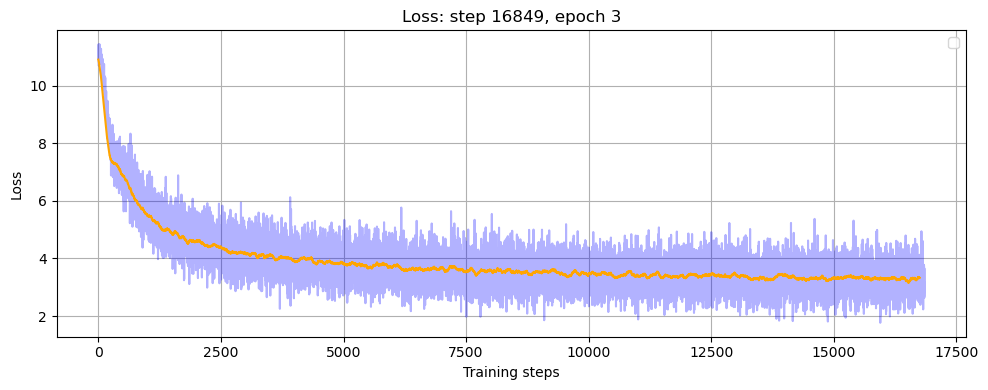

In [7]:
from transformers import DataCollatorForLanguageModeling
from torch.utils.data import DataLoader

dataset_dict = tokenized.train_test_split(test_size=0.1, seed=42)
train_ds = dataset_dict["train"]
val_ds   = dataset_dict["test"]

collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15
)

train_dataloader = DataLoader(
    train_ds,
    batch_size=16,
    shuffle=True,
    collate_fn=collator
)

val_dataloader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    collate_fn=collator
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

from transformers import get_scheduler

for name, param in model.named_parameters():
    if name.startswith("bert.embeddings") or name.startswith("bert.encoder.layer.0") or \
       name.startswith("bert.encoder.layer.1"):
        param.requires_grad = False

frozen = [name for name, param in model.named_parameters() if not param.requires_grad]
print(f"Заморожено {len(frozen)} параметров из {len(list(model.named_parameters()))}")
    
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=2e-5, betas=(0.9, 0.999), eps=1e-08)

num_epochs = 3
warmup_factor = 0.1

batch_size = 16
batches_per_epoch= len(train_dataloader)
num_training_steps = num_epochs * batches_per_epoch

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=int(warmup_factor * num_training_steps),
    num_training_steps=num_training_steps,
)

import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from IPython.display import clear_output
import numpy as np
import os

def smooth(values, window=100):
    if len(values) < window:
        return values  # слишком мало данных
    return np.convolve(values, np.ones(window)/window, mode='valid')

output_dir = "loss_plots"
os.makedirs(output_dir, exist_ok=True)

import csv

log_path = "training_log.csv"
with open(log_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=[
        "step","epoch", "train_loss", "val_loss", "lr"
    ])
    writer.writeheader()

scaler = GradScaler()
train_losses=[]
val_losses=[]
train_steps=[]
val_steps=[]

for epoch in range(num_epochs):
    model.train()
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")
    for step, batch in enumerate(loop):
        total_step = (step+1)+epoch*len(train_dataloader)
        batch = {k: v.to(device) for k, v in batch.items()}

        with autocast():
            outputs = model(**batch)
            loss = outputs.loss
        
        scaler.scale(loss).backward()
        # clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        lr_scheduler.step()

        # # более простой вариант 
        # outputs = model(**batch)
        # loss = outputs.loss

        # loss.backward()
        # optimizer.step()
        # lr_scheduler.step()
        # optimizer.zero_grad()
        
        train_steps.append(total_step)
        train_losses.append(loss.item())

        if (total_step + 1) % 50 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(10, 4))
            plt.plot(train_steps, train_losses, color='blue', alpha=0.3)
            plt.plot(smooth(train_losses), color='orange')
            plt.xlabel("Training steps")
            plt.ylabel("Loss")
            plt.title(f"Loss: step {total_step}, epoch {epoch+1}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()

            filename = os.path.join(output_dir, f"loss_bert_finetune.png")
            plt.savefig(filename)
            plt.show()

        if (total_step + 1) % 1500 == 0:
            print(f"Validation")
            model.eval()
            val_losses_temp=[]
            with torch.no_grad():
                for batch in tqdm(val_dataloader):
                    batch = {k: v.to(device) for k, v in batch.items()}
                    outputs = model(**batch)
                    val_losses_temp.append(outputs.loss.item())
            avg_val_loss = np.mean(val_losses_temp)
            
            val_losses.append(avg_val_loss)
            val_steps.append(total_step)

            current_lr = lr_scheduler.get_last_lr()[0]

            with open(log_path, "a", newline="") as f:
                writer = csv.DictWriter(f, fieldnames=[
                    "step","epoch", "train_loss", "val_loss", "lr"
                ])
                writer.writerow({
                    "step": total_step,
                    "epoch": epoch + 1,
                    "train_loss": np.mean(train_losses[-100:]),
                    "val_loss": avg_val_loss,
                    "lr": current_lr
                })
            model.train()


In [8]:
model.save_pretrained("model")
# можно ограничиться 8200 шагами при размере батча 16
# tokenizer.save_pretrained("models")

In [11]:
tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

In [9]:
next(iter(train_dataloader))

{'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'input_ids': tensor([[  101,   103,  1192,  ...,     0,     0,     0],
        [  101,   146,  1767,  ...,     0,     0,     0],
        [  101,   157,  2162,  ...,     0,     0,     0],
        ...,
        [  101,  4596, 23630,  ...,     0,     0,     0],
        [  101,   146,   112,  ...,     0,     0,     0],
        [  101,  1335,  1103,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'labels': tensor([[-100,  128, -100,  ..., -100, -100, -100],
        [-100, -100, 1767,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -1

In [10]:
print(tokenizer.decode(tokenized[10]['input_ids']))

[CLS] no it wasn't that but it was mostly my fault... in october 2010i was coming home driving up an interstate where the speed limit is usually 70 but i was in a work zone that didn't have workers so the speed limit was 55 which i was doing until like the last quarter mile where i know it ended and goes back up to 70 and got pulled over got a ticket... the cop wasn't really paying attention he said he was watching for a stolen car so he didn't tell me that they don't mail you the ticket which they do in my home town... i thought what he gave me was just the thing that tells you what you got pulled over for... so anyway put that ina drawer and forgot about it for months.... theeeen got pulled over in november 2011 for drivin with a suspended license and i guess it had been suspended for awhile and the cop was super cool about it he said if my car wasn't so cool he would have towed my car but he told me to just drive home and not to drive until i got it taken care of... so i do that and

In [10]:
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr